## Deconvolution Simulation Experiments 2
#### Christa Caggiano 
#### July 18th 2018 


Simulations for cfDNA tissue of origin deconvolution. Given an observed matrix of methylation counts for each CpG from whole genome bisulfite sequencing, and a reference matrix of the cannonical proportion methylation for each CpG in each tissue, estimates how much of the cfDNA comes from each tissue in the reference. 

These simulations generate a variety of 'true' proportions and test how well our current algorithm is at recapitulating that proportion. 

In [2]:
#### python packages ####
import pandas as pd
import numpy as np 
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import binom
%matplotlib inline

######### loading my python modules for deconvolution ########### 
#### https://github.com/christacaggiano/cfDNA-deconvolution #####

# this code needed to load my modules in a jupyter notebook 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from simulation.simulation_utils import *  # various utils for making simulated data 
from simulation.simulate import generate_simulated_optimization  # takes parameters and makes simulated matrices for optimization 
from optimization.quadratic_programming_optimization import perform_optimization as qp  # performs quadratic programming optimization
from optimization.naive_optimization import perform_optimization as naive  # 'naive' optimization that divides by sum 

#### Load data

Same as in previous set of experiments. 

In [3]:
# Tissues included in this data set, in the order that they appear
# neurosphere	liver	brain_germinal	brain_hipp	atrium 	ventricle	thymus 	spleen	cd34	4star

roadmap_dmrs = pd.read_csv("../data/deconvolution_exp1_10_tissues.csv")  # load in the roadmap dmrs
roadmap_dmrs_drop_na = roadmap_dmrs.dropna()  # for now, just drop any missing data. Later experiments will test ways of dealing with Na's more intelligently 

In [4]:
roadmap_dmrs = roadmap_dmrs_drop_na.iloc[:, 3:] # drop chrom information because it's not important for computation 
roadmap_dmrs["var"] = roadmap_dmrs.var(axis=1, skipna=True)  # calculate row variance 
roadmap_dmrs_top10000 = roadmap_dmrs.sort_values(by="var", ascending=False).iloc[:10000,:-1]  # take the top 10,000 most variable sites 

In [5]:
reference = roadmap_dmrs_top10000.as_matrix().T

#### Experiment 2A

__*Goal*__: How well can our algorithm estimate tissues *not* contained in the reference panel? 

**Outline** 
* Find the two most similar tissues 
* Eliminate one tissue from the reference and examine whether algorithm picks most similar tissue for the estimation. 
* Perform across a range of read depths

#### Assess similarity

In [6]:
# pairwise pearson's correlation coefficient between top 10,000 variable sites 
corr = np.corrcoef(reference) 

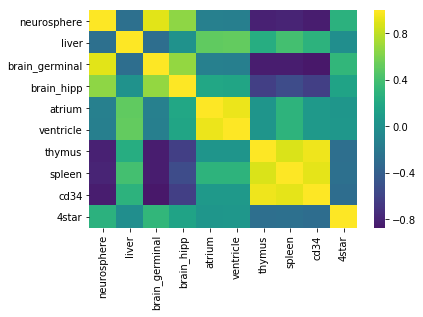

In [7]:
# plot a heatmap of the correlation coefficients to pick pairs of tissues to test on 

labels = ["neurosphere","liver","brain_germinal","brain_hipp","atrium","ventricle","thymus","spleen","cd34","4star"]
sns.heatmap(corr, cmap="viridis", center=0.0, xticklabels=labels, yticklabels=labels)

plt.show()

__*Plot 1*__: For the top 10,000 variable sites in the roadmap reference, the Pearson's correlation coefficients between each tissue 

__Observation__: Atrium and ventricle are highly correlated. I am surprised that cd34 cells are so highly correlated with spleen and thymus and that brain is so different than other organs. It seems like 4star is mostly different from everything, neurosphere and brain germinal matrix are very different than thymus/spleen/cd34. 

#### Remake reference

Assume the two most correlated tissues in the reference are atrium and ventricle. Take out atrium and keep ventricle in the reference. 

In [8]:
atrium = reference[4, :]  # set aside  atrium to make up observations 
ref_no_atrium = np.delete(reference, [4], axis=0)  # drop atrium from the reference 

#### Optimization Function

Write a simpler optimization master function, since we no longer need to simulate observed as a function of tissue %; instead the observed matrix will simply be the tissue dropped from the reference. 

In [9]:
# instead of simulating observed proprotions, we are going to premake the matrix, since it is no longer just
# a function of only the reference 

def generate_optimization(reference, methylated, unmethylated, method):
    """
    using predefined reference and observed proportions, runs an optimization algorithm of choice 
    :param reference (np.array) array of methylation observations 
    :param methylated (np.array)array of methylated counts 
    :param unmethylated (np.array) array of unmethylated counts 
    :param method (string) optimization method
    
    :return estimated proportions  
    
    """
    
    # create initial proportions estimates 
    proportions_est = np.zeros((1, reference.shape[0])) + 0.5  
    proportions_est = proportions_est / (np.sum(proportions_est))

    return method(proportions_est, reference, methylated, unmethylated)

#### Parameters

Keep parameters simple, as in the first experiments. Perform across our standard read depth range. This time, however, keep the tissue of interest as the ventricle. 

In [10]:
read_depths = [10, 30, 100, 1000]
individuals = 1  
sites = ref_no_atrium.shape[1] 
tissue_of_interest = 4  # set ventricle as tissue of interest 
method = qp 
noise = 0  
replicates = 10 

#### Create Observations 

Create observations that are the proportions of true atrium, drawing from poisson distributions using the various read depths as number of counts to draw from. 

In [11]:
# start off by defining the true observed as 100% atrium 

observed = atrium
observed = observed.reshape(1, len(atrium))

count_matrices = [] 

for read_depth in read_depths: 
    depth = generate_depth(sites, individuals, read_depth)
    methylated = generate_counts(depth, observed, sites, individuals)  # generate counts using poisson distribution 
    unmethylated = depth - methylated
    
    count_matrices.append((methylated, unmethylated))  # keep track of different observations 

#### Simulation

Run simulation for each observed matrix drawn above. 

In [12]:
estimate = []

for observed in count_matrices: 
    methylated, unmethylated = observed
    guess = generate_optimization(ref_no_atrium, methylated, unmethylated, qp)
    estimate.append(guess) 


#### Plot

Plot a simple bar chart of the optimization estimates given for each tissue. 

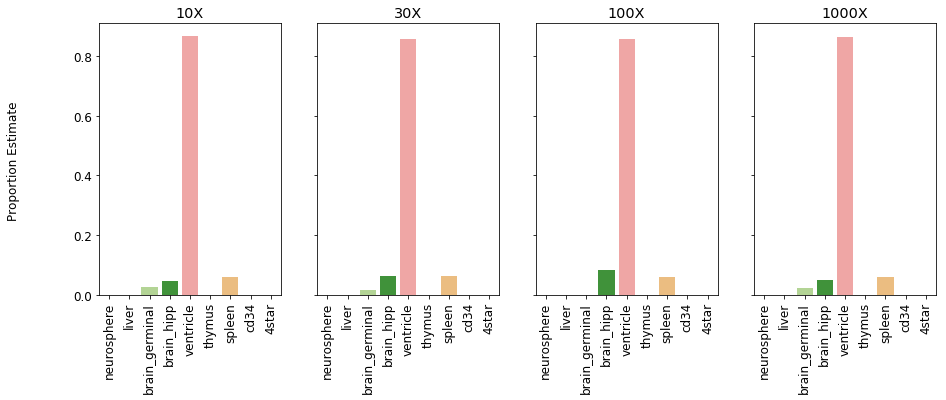

In [13]:
# bar plot of each of the estimates 
# todo, add error bars 

plt.rcParams.update({'font.size': 12})

fig, axes = plt.subplots(1, len(estimate), sharey=True, figsize=(15, 5)) # makes subplots that share a y axis
axes.ravel()

labels = ["neurosphere","liver","brain_germinal","brain_hipp","ventricle","thymus","spleen","cd34","4star"]

for i in range(len(estimate)): 
    sns.barplot(labels, estimate[i], ax=axes[i], palette="Paired")
    axes[i].set_xticklabels(labels, rotation=90)
    axes[i].set_title(str(read_depths[i]) + "X")
    
fig.text(0.04, 0.5, 'Proportion Estimate', va='center', rotation='vertical')

plt.show()


__*Plot 8*__: Proportion estimate for each tissue at different read depths 

__Obersevation__: This seems mostly what would be expected. Interested in what would be given for more complex mixtures

In [14]:
# get an idea for the spread of error/correlation, not just the mean 

all_replicates = []

for observed in count_matrices:
    guesses = []
    for i in range(replicates): 
        methylated, unmethylated = observed
        guess = generate_optimization(ref_no_atrium, methylated, unmethylated, qp)
        guesses.append(guess) 
        
    all_replicates.append(guesses)
    

In [15]:
# make array for better plotting 
a = np.array(all_replicates)

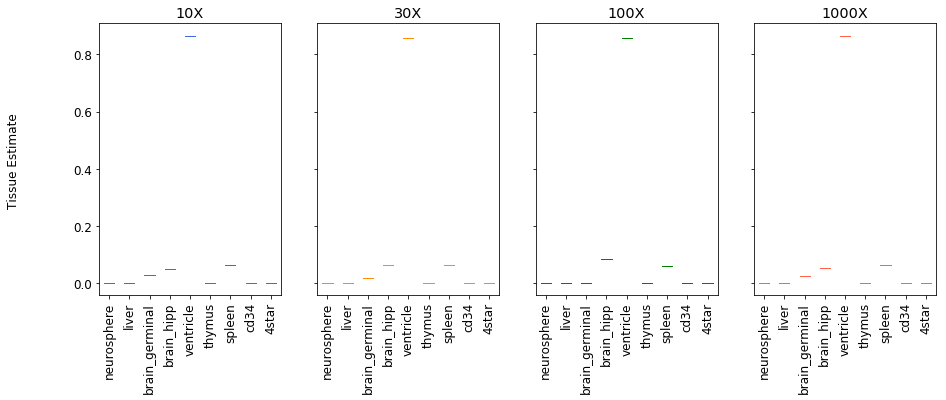

In [16]:
# make box plot of the error over 10 replicates 

plt.rcParams.update({'font.size': 12})

labels = ["neurosphere","liver","brain_germinal","brain_hipp","ventricle","thymus","spleen","cd34","4star"]

fig, axes = plt.subplots(1, len(a), sharey=True, figsize=(15, 5)) # makes subplots that share a y axis
axes.ravel()

colors = ["royalblue", "darkorange", "green", "tomato"]  # set colors (default is white)
for i, c in zip(range(len(a)), colors): 
    
    axes[i].boxplot(a[i], patch_artist=True, # patch artist necessary to set color 
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))
    
    axes[i].set_title(str(read_depths[i]) + "X")
    axes[i].set_xticklabels(labels, rotation=90)

    
# gives commmon axis labels 
fig.text(0.04, 0.5, 'Tissue Estimate', va='center', rotation='vertical')

plt.show()



__*Plot 9*__: Mean estimate for ten replicates for plot 8 

__Observation__: I'm a little surprised that there is no variation between replicates ?

### Experiment 2a 
* using the same parameters, but instead of a tissue completely outside the reference panel, use a biological replicate of one tissue 

#### Reload Data

In [17]:
# Tissues included in this data set, in the order that they appear
roadmap_dmrs = pd.read_csv("../data/deconvolution_exp2_10_tissues_rep.csv")  # load in the roadmap dmrs
roadmap_dmrs_drop_na = roadmap_dmrs.dropna()  # for now, just drop any missing data. Later experiments will test ways of dealing with Na's more intelligently 
list(roadmap_dmrs)

['chr',
 'start',
 'end',
 'methylation_level_E054',
 'methylation_level_E066',
 'methylation_level_E070',
 'methylation_level_E071_149',
 'methylation_level_E104',
 'methylation_level_E105',
 'methylation_level_E112',
 'methylation_level_E113',
 'methylation_level_E050_RO_01549',
 'methylation_level_E024_A21771',
 'methylation_level_E071_150']

In [18]:
# reload data with the new biological replicate, and process the data similarly to experiment 1 

roadmap_dmrs_no_rep = roadmap_dmrs_drop_na.iloc[:, 3:-1] # drop replicate column 
print(list(roadmap_dmrs_no_rep))
roadmap_dmrs_no_rep["var"] = roadmap_dmrs_no_rep.var(axis=1, skipna=True)  # calculate row variance 
roadmap_dmrs_top10000 = roadmap_dmrs_no_rep.sort_values(by="var", ascending=False).iloc[:10000,:-1]  # take the top 10,000 most variable sites 

['methylation_level_E054', 'methylation_level_E066', 'methylation_level_E070', 'methylation_level_E071_149', 'methylation_level_E104', 'methylation_level_E105', 'methylation_level_E112', 'methylation_level_E113', 'methylation_level_E050_RO_01549', 'methylation_level_E024_A21771']


In [19]:
brain_rep = roadmap_dmrs_drop_na.iloc[:, 3]  # make the replicate with the same dimesions as the top 10,000 variable sites
brain_rep_var = brain_rep[brain_rep.index.isin(roadmap_dmrs_top10000.index)]

In [20]:
observed = brain_rep_var.as_matrix().T # keep as a column vector
reference = roadmap_dmrs_top10000.as_matrix().T  # transpose for computation 

#### Parameters

In [21]:
read_depths = [10, 30, 100, 1000]
individuals = 1  
sites = reference.shape[1]  
method = qp 
replicates = 1

In [22]:
observed = observed.reshape(1, len(brain_rep_var))

count_matrices = [] 

for read_depth in read_depths: 
    depth = generate_depth(sites, individuals, read_depth)
    methylated = generate_counts(depth, observed, sites, individuals)
    unmethylated = depth - methylated
    
    count_matrices.append((methylated, unmethylated))

#### Run Optimization

In [23]:
estimates = []
guesses = []
truth = np.zeros((1, len(reference)))
truth[:,tissue_of_interest] = 1 

for observed in count_matrices:
    error = 0 
    for i in range(replicates): 
        methylated, unmethylated = observed
        guess = generate_optimization(reference, methylated, unmethylated, qp)
        guesses.append(guess)
        error += (np.corrcoef(truth, guess)[0][1]) 
    estimates.append(error/replicates)

In [24]:
print(guesses)

[array([6.60007869e-02, 0.00000000e+00, 3.89734316e-01, 5.37709414e-02,
       5.76405466e-02, 2.69897901e-14, 1.90128403e-15, 2.14739873e-01,
       2.18113536e-01, 0.00000000e+00]), array([0.00000000e+00, 1.38934616e-14, 4.78668635e-01, 0.00000000e+00,
       0.00000000e+00, 2.09033492e-02, 4.02459677e-02, 4.60124921e-01,
       5.71271047e-05, 2.12965547e-13]), array([9.18973388e-02, 0.00000000e+00, 3.44669207e-01, 6.33025320e-02,
       3.72213214e-02, 1.34244066e-10, 1.91256233e-02, 4.05063310e-01,
       3.87206670e-02, 0.00000000e+00]), array([6.33105153e-02, 4.65235532e-13, 3.92442947e-01, 5.44843577e-02,
       6.47270224e-02, 2.01483074e-08, 1.48886873e-13, 2.10658215e-01,
       2.14376980e-01, 2.21614741e-12])]


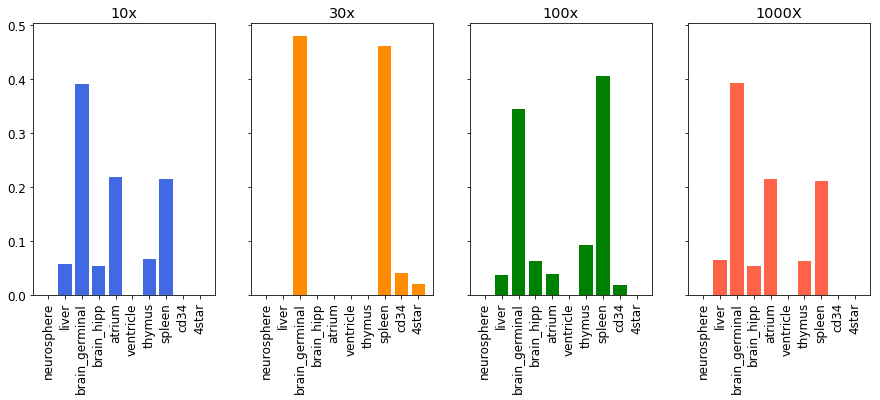

In [25]:
# bar plot of each of the estimates 
# todo, add error bars 

plt.rcParams.update({'font.size': 12})

fig, axes = plt.subplots(1, len(guesses), sharey=True, figsize=(15, 5)) # makes subplots that share a y axis
axes.ravel()

labels = ["neurosphere","liver","brain_germinal","brain_hipp", "atrium", "ventricle","thymus","spleen","cd34","4star"]
depth_titles = ["10x", "30x", "100x", "1000X"]

colors = ["royalblue", "darkorange", "green", "tomato"]  # set colors 
for i in range(len(guesses)): 
    axes[i].bar(labels, guesses[i], color=colors[i])
    axes[i].set_xticklabels(labels, rotation=90)
    axes[i].set_title(depth_titles[i])
        


Text(0,0.5,'Correlation')

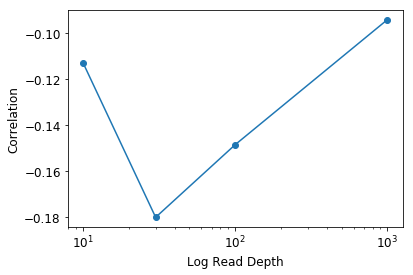

In [26]:
# plot the correlation vs read depth 

plt.rcParams.update({'font.size': 12})

plt.plot(read_depths, estimates, '-o')
plt.xscale("log")
    
plt.xlabel("Log Read Depth")
plt.ylabel("Correlation")
